In [1]:
from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TSContinuous
import librosa
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import soundfile as sf

WARNING    /home/timon-l/devel/CITS5551/AcousticTrafficMonitoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]
  from .autonotebook import tqdm as notebook_tqdm



In [2]:
def audio_to_features(
    input_path: str,
    output_dir: str,
    target_sr: int = 16000
) -> str:
    fs = 110e3
    raster_period = 10e-3
    max_spike_per_raster_period = 15

    add_noise = False
    add_offset = False
    add_mismatch = False
    seed = None

    if not os.path.exists(input_path):
        logging.error("File does not exist")
        return ""

    y, sr = librosa.load(input_path, sr=target_sr, mono=True)

    dt = 1 / target_sr  # Time step
    audio_ts = TSContinuous.from_clocked(
        y,
        dt=dt,
        name="Audio input"
    )

    afe = AFESim(
        fs=fs,
        raster_period=raster_period,
        max_spike_per_raster_period=max_spike_per_raster_period,
        add_noise=add_noise,
        add_offset=add_offset,
        add_mismatch=add_mismatch,
        seed=seed,
    ).timed()

    features, stat, rec = afe(audio_ts, record=True)

    """ fig = plt.figure()
    ax = fig.add_subplot(211)
    audio_ts.plot()

    ax = fig.add_subplot(212)
    ax.specgram(y, Fs=fs)
    ax.set_ylim([0, 8000])
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_title("Spectrogram") """

    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(211)
    audio_ts.plot()
    ax.set_xticks([])
    ax.set_xlabel("")

    """ fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(511)
    audio_ts.plot()
    ax.set_xticks([])
    ax.set_xlabel("")

    ax = fig.add_subplot(512)
    rec["LNA_out"].plot()
    ax.set_xticks([])
    ax.set_xlabel("")

    ax = fig.add_subplot(513)
    rec["BPF"].plot()
    ax.set_xticks([])
    ax.set_xlabel("")

    ax = fig.add_subplot(514)
    rec["rect"].plot()
    ax.set_xticks([])
    ax.set_xlabel("") """

    ax = fig.add_subplot(212)
    plt.imshow(
        features.raster(dt=10e-3, add_events=True).T, aspect="auto", origin="lower"
    )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Output channel")
    ax.set_title("Spiking output")

    #os.makedirs(output_dir, exist_ok=True)
    #filename = os.path.basename(input_path).replace(".flac", ".npy")
    #out_path = os.path.join(output_dir, filename)
    #np.save(out_path, features)

    return ""

In [3]:
def normalize_audio(y):
    y_normalized = librosa.util.normalize(y)
    return y_normalized

In [ ]:
def segment_and_filter(input_path, output_dir, segment_length=8, energy_threshold=-40):
    # Load audio
    y, sr = librosa.load(input_path, sr=None)

    # Split into x-second segments
    segment_samples = sr * segment_length
    segments = [y[i:i+segment_samples] for i in range(0, len(y), segment_samples)]

    os.makedirs(output_dir, exist_ok=True)

    # Save valid segments
    valid_segments = []
    for i, seg in enumerate(segments):
        # Compute energy (dB)
        rms = librosa.feature.rms(y=seg)
        db = librosa.amplitude_to_db(rms)
        avg_db = np.mean(db)

        #print(avg_db)

        # Check energy threshold
        if avg_db > energy_threshold:
            valid_segments.append(seg)
            sf.write(f"{output_dir}/segment_{i}.flac", seg, sr)

    return valid_segments

In [5]:
def augment_cv(audio, sr, noise_path=None):
    augmented = []

    # Time-domain: Reverse audio
    reversed_audio = audio[::-1]
    augmented.append(reversed_audio)

    # Speed change (0.9x and 1.1x)
    for rate in [0.9, 1.1]:
        y_stretch = librosa.effects.time_stretch(audio, rate=rate)
        augmented.append(y_stretch)

    # Add background noise
    if noise_path:
        noise, _ = librosa.load(noise_path, sr=sr)
        min_len = min(len(audio), len(noise))
        mixed = audio[:min_len] + 0.2 * noise[:min_len]  # Adjust noise level
        augmented.append(mixed)

    return augmented

/home/timon-l/devel/CITS5551/AcousticTrafficMonitoring/DataPreprocessing
-59.220272
-59.285847
-58.98751
-59.33104
-59.512615
-59.36942
-59.042213
-54.998714
-57.65772
-61.91038
-61.867462
-55.24319
-61.631893
-57.70367
-59.69259
-56.05425
-57.256657
-56.682575
-53.887638
-52.682846
-55.99135
-56.069687
-56.51424
-56.50216
-63.093094
-62.73998
-63.385998
-63.281006
-63.171253
-63.054638
-63.303493
-63.689484
-62.845993
-56.581036
-62.648716
-58.54636
-60.602287
-55.661198
-61.595715
-63.28303
-57.904682
-57.817993
-54.69398
-61.31964
-56.64685
-60.170155
-61.53618
-62.75122
-61.607677
-59.47725
-61.462036
-62.33326
-62.129818
-60.809624
-53.171803
-60.16087
-63.380726
-58.0491
-61.8428
-57.859177
-60.282597
-54.983013
-57.515587
-57.27013
-59.268272
-58.905876
-63.08001
-61.96543
-57.269096
-54.397095
-60.86981
-61.698383
-60.928993
-60.676643
-60.5814
-60.098713
-60.084892
-58.5807
-58.356155
-57.90586
-59.519463
-56.808376
-54.71847
-52.652428
-58.394634
-59.21963
-60.26245
-60.40744

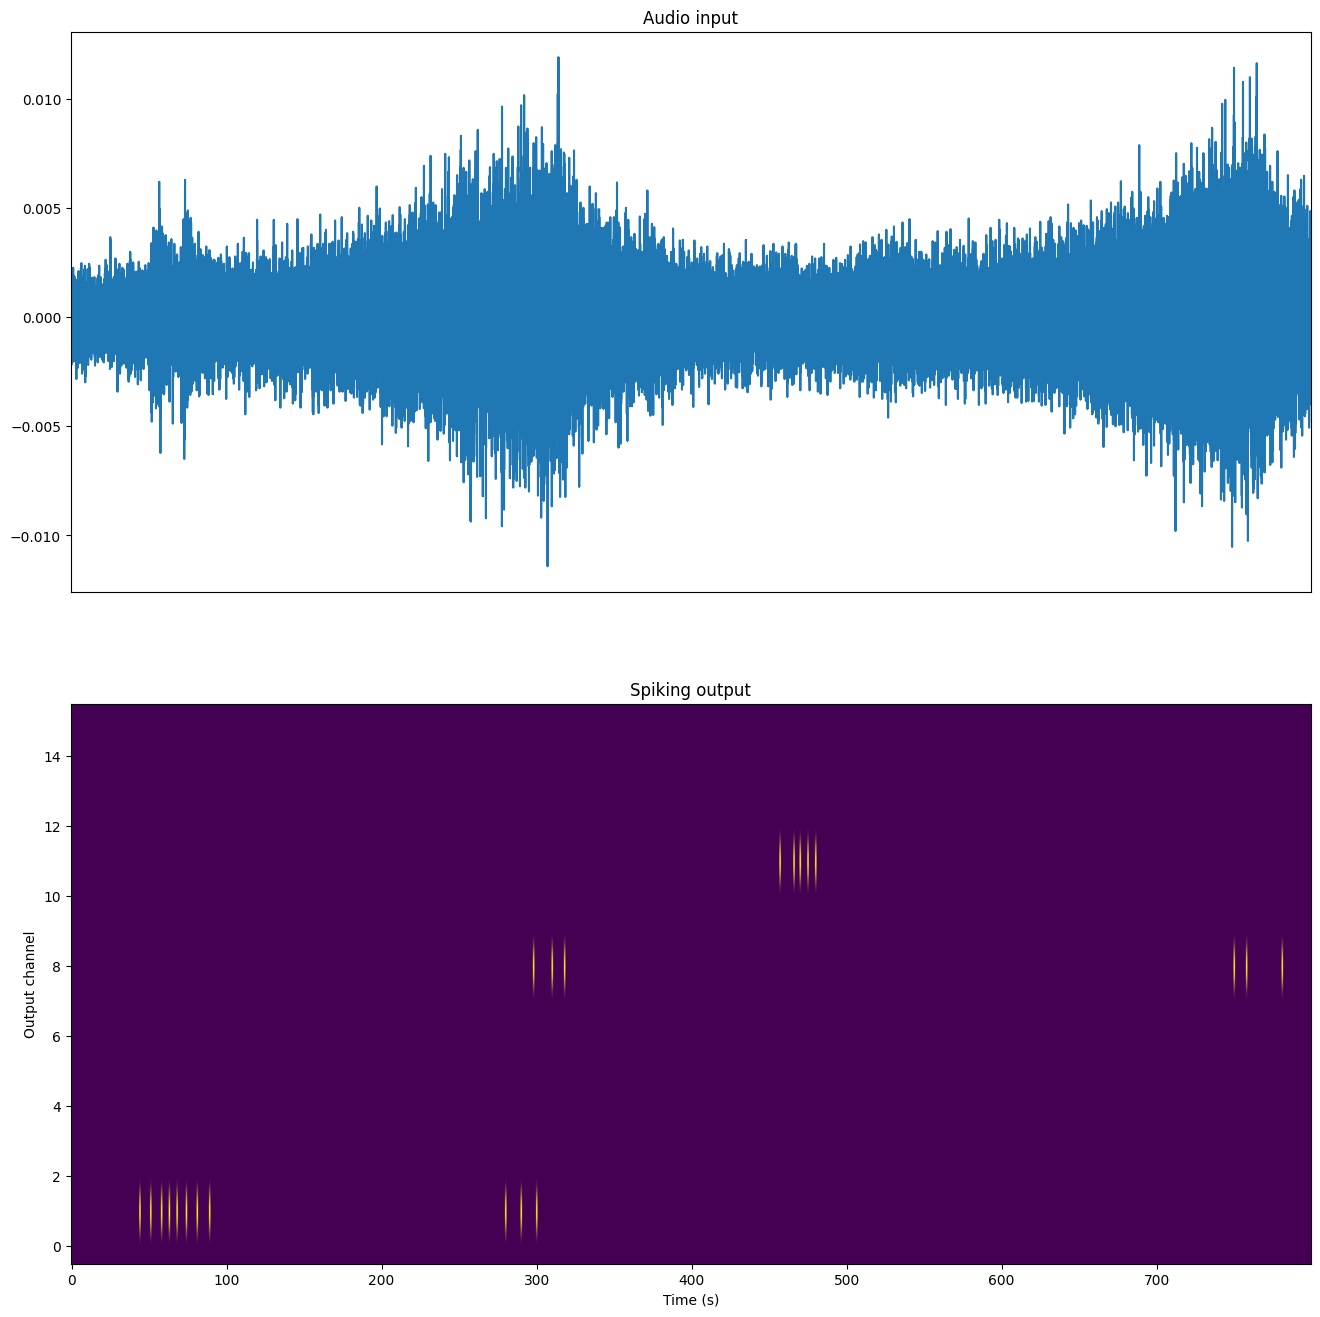

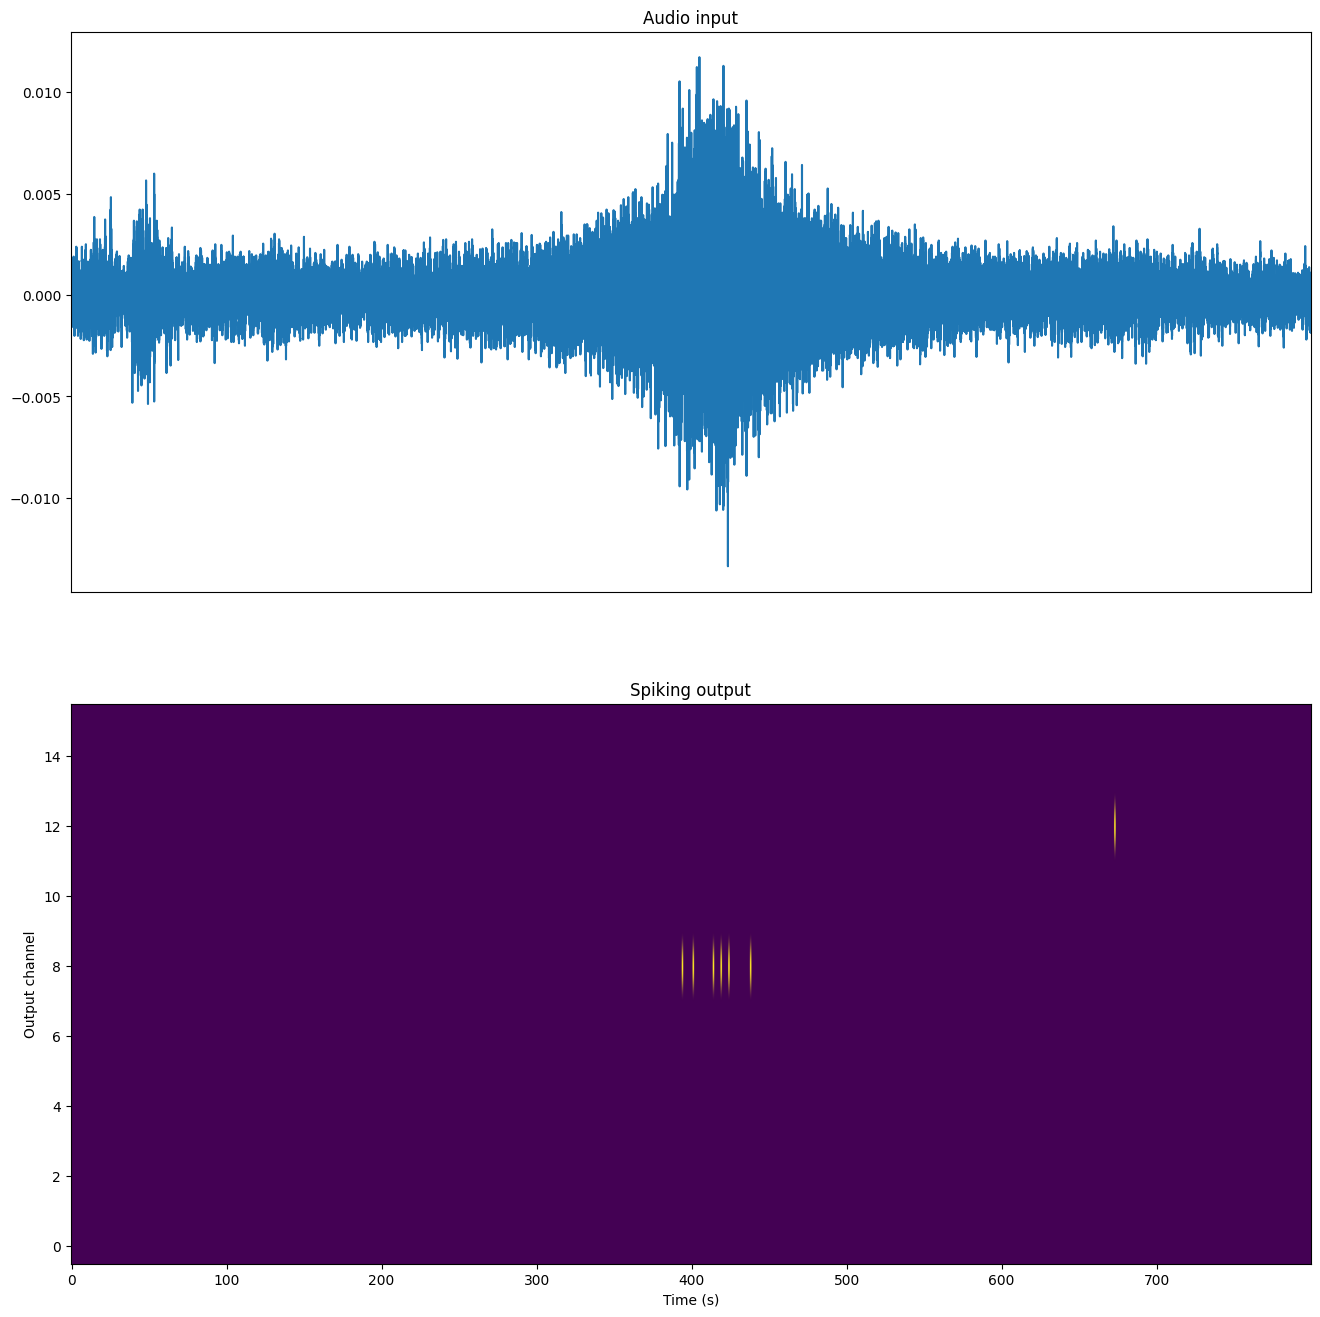

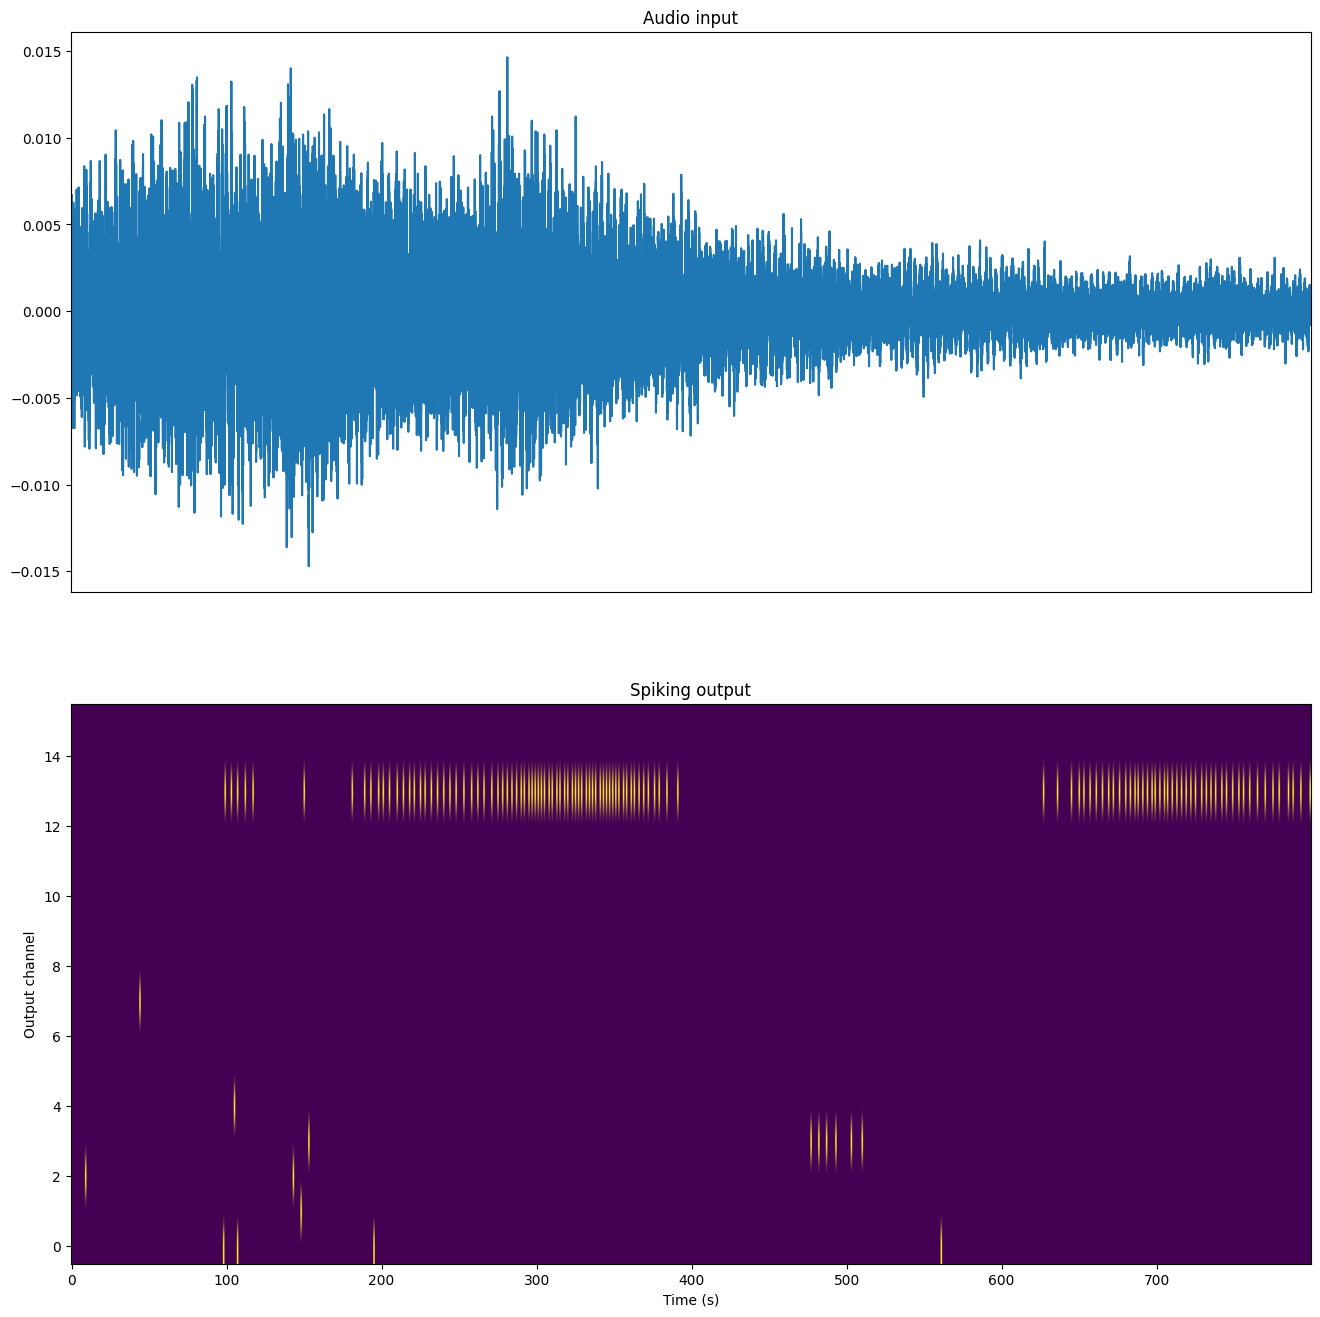

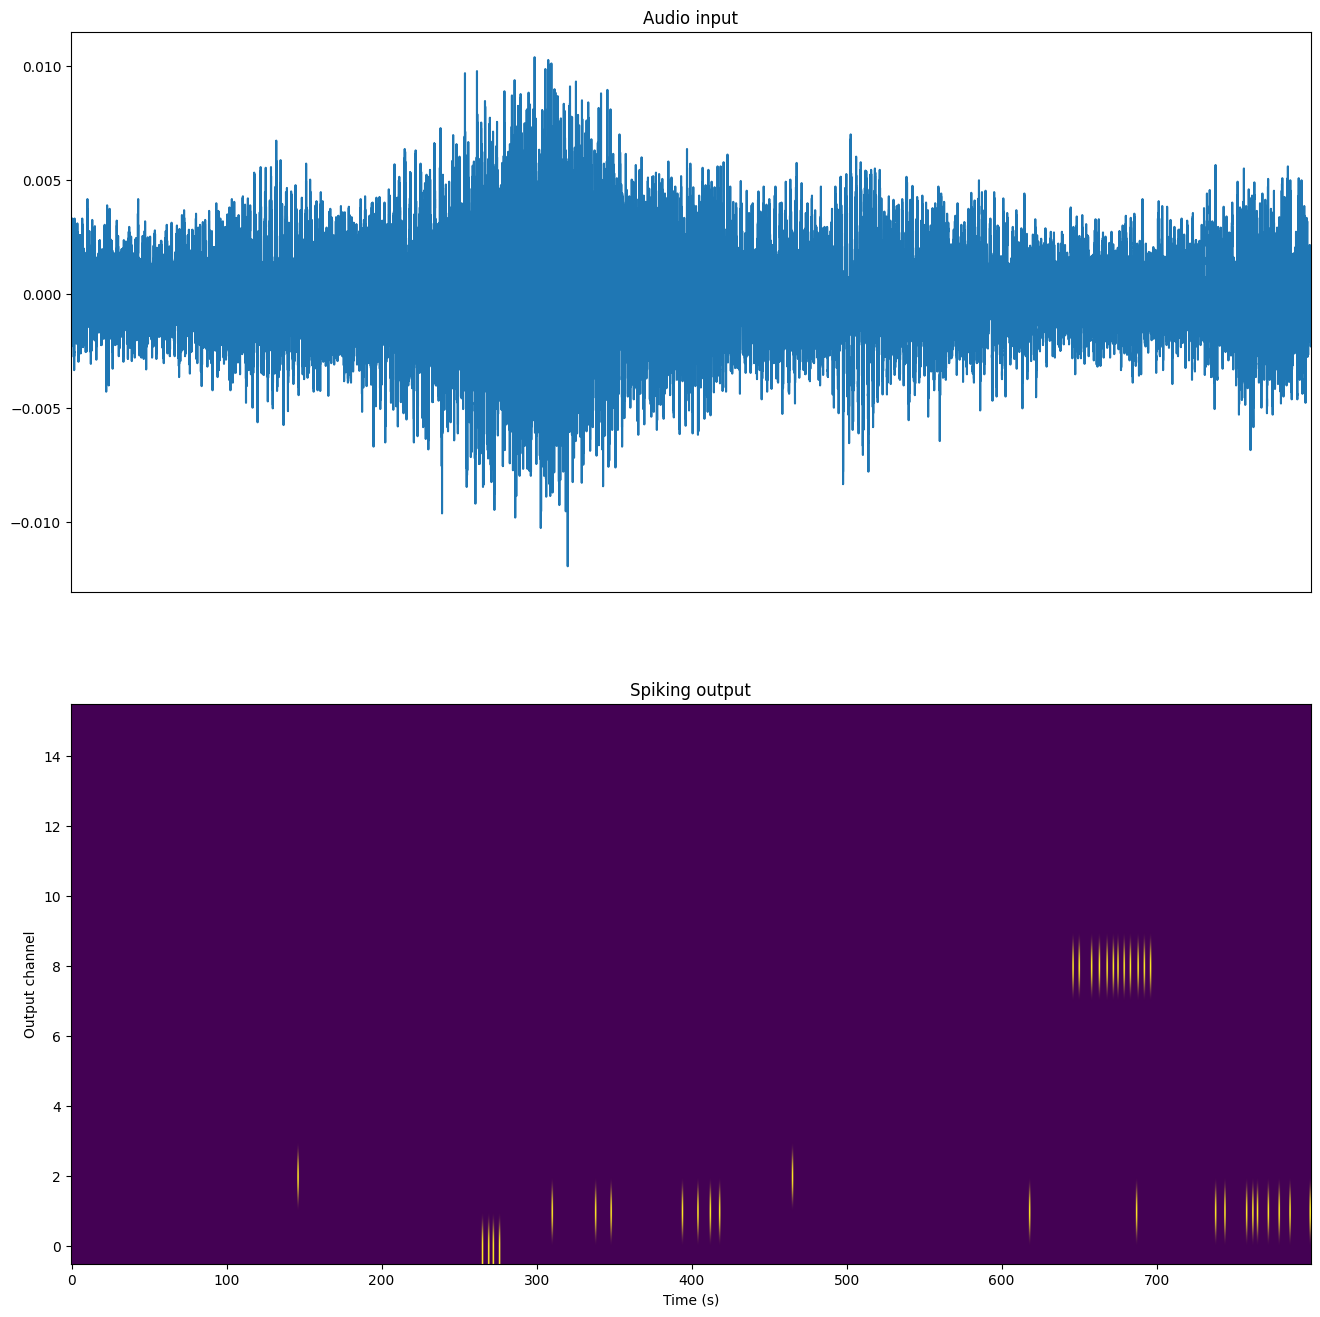

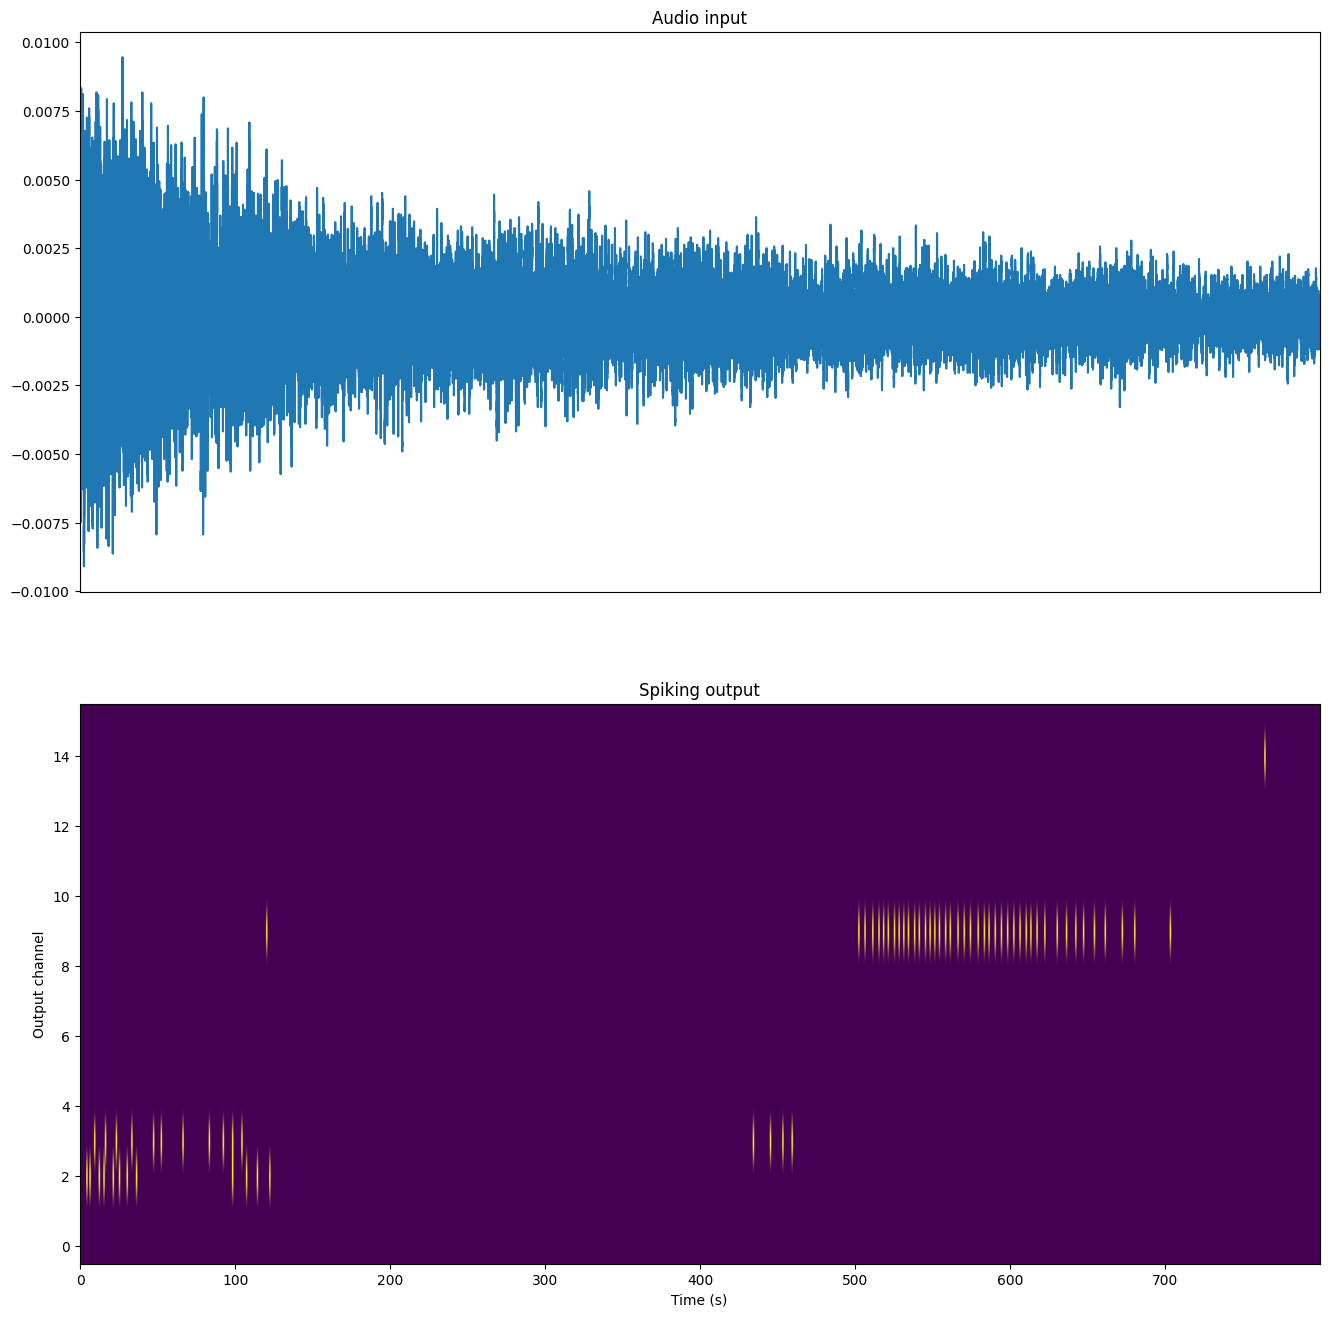

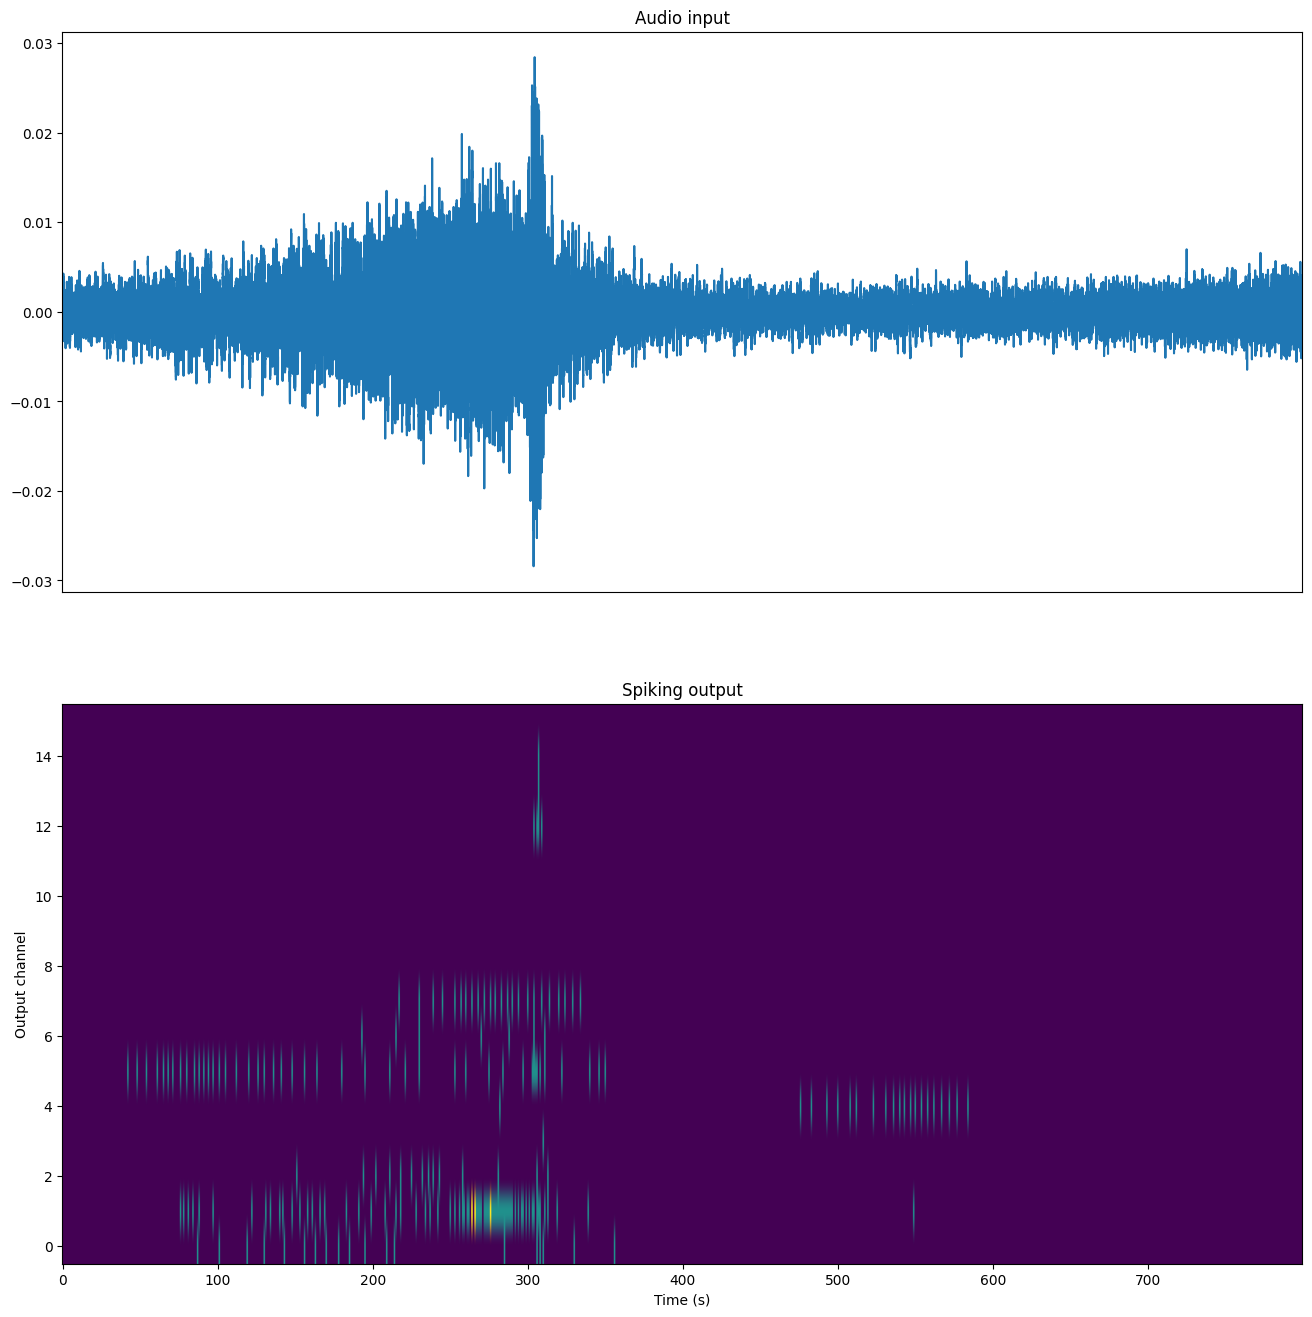

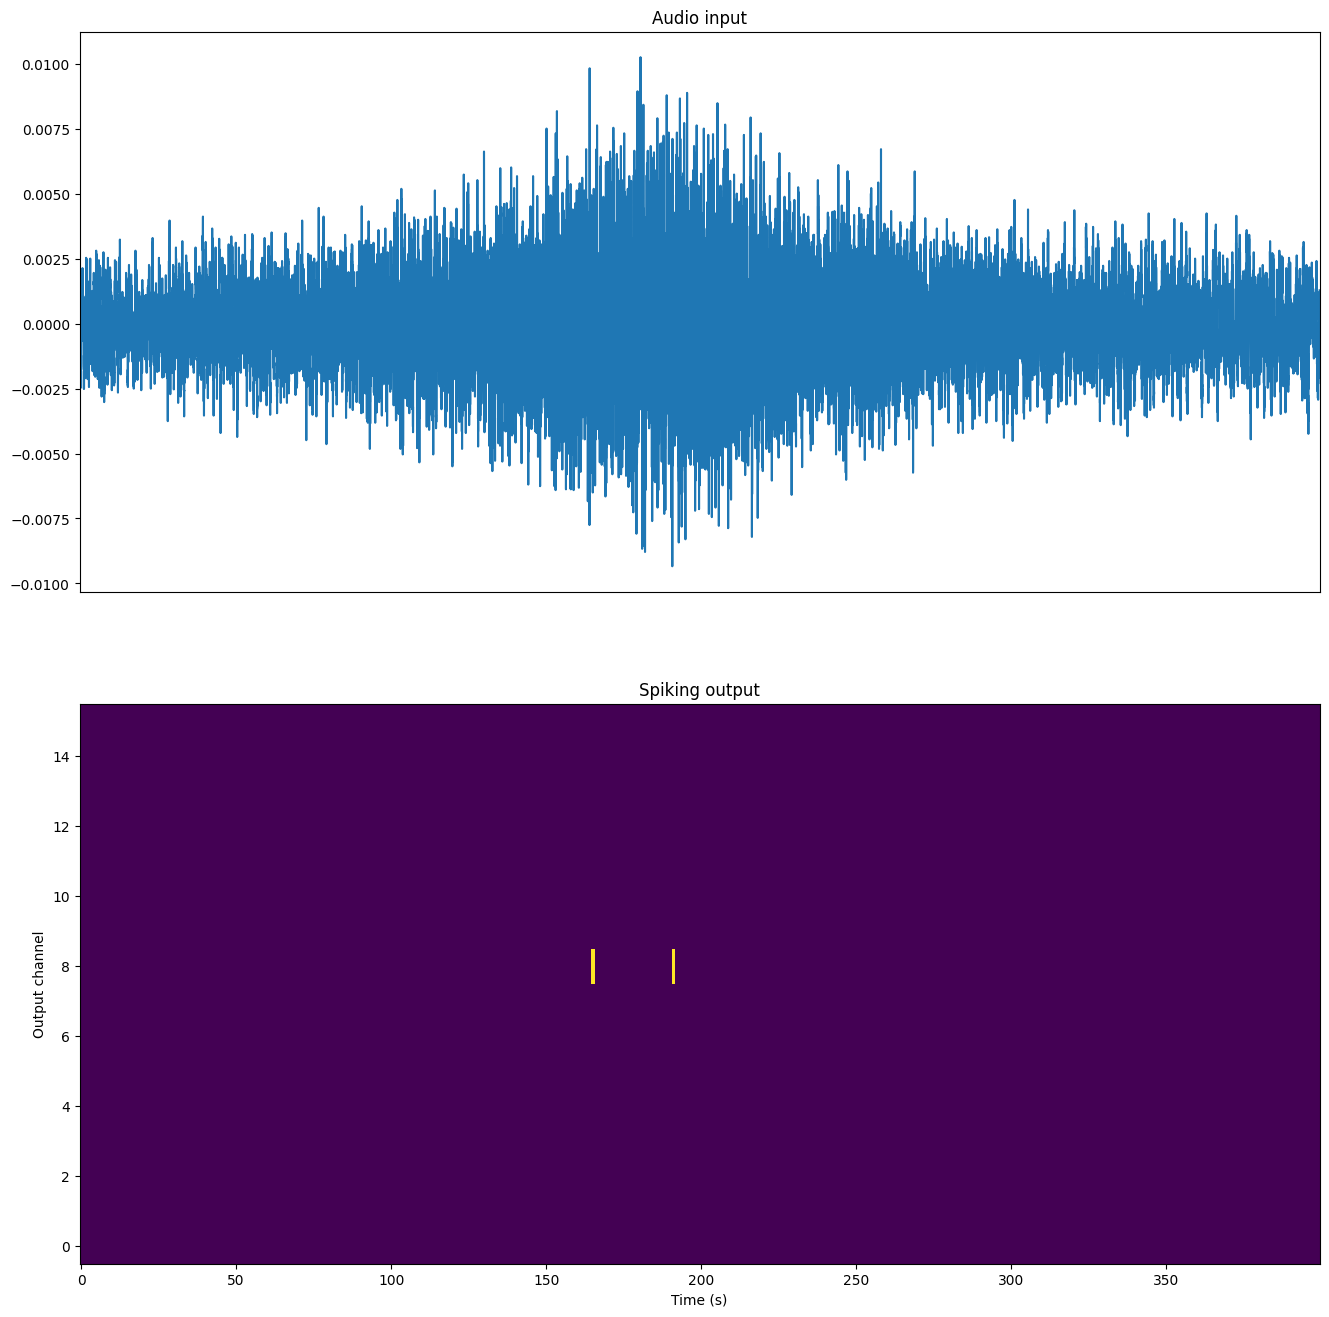

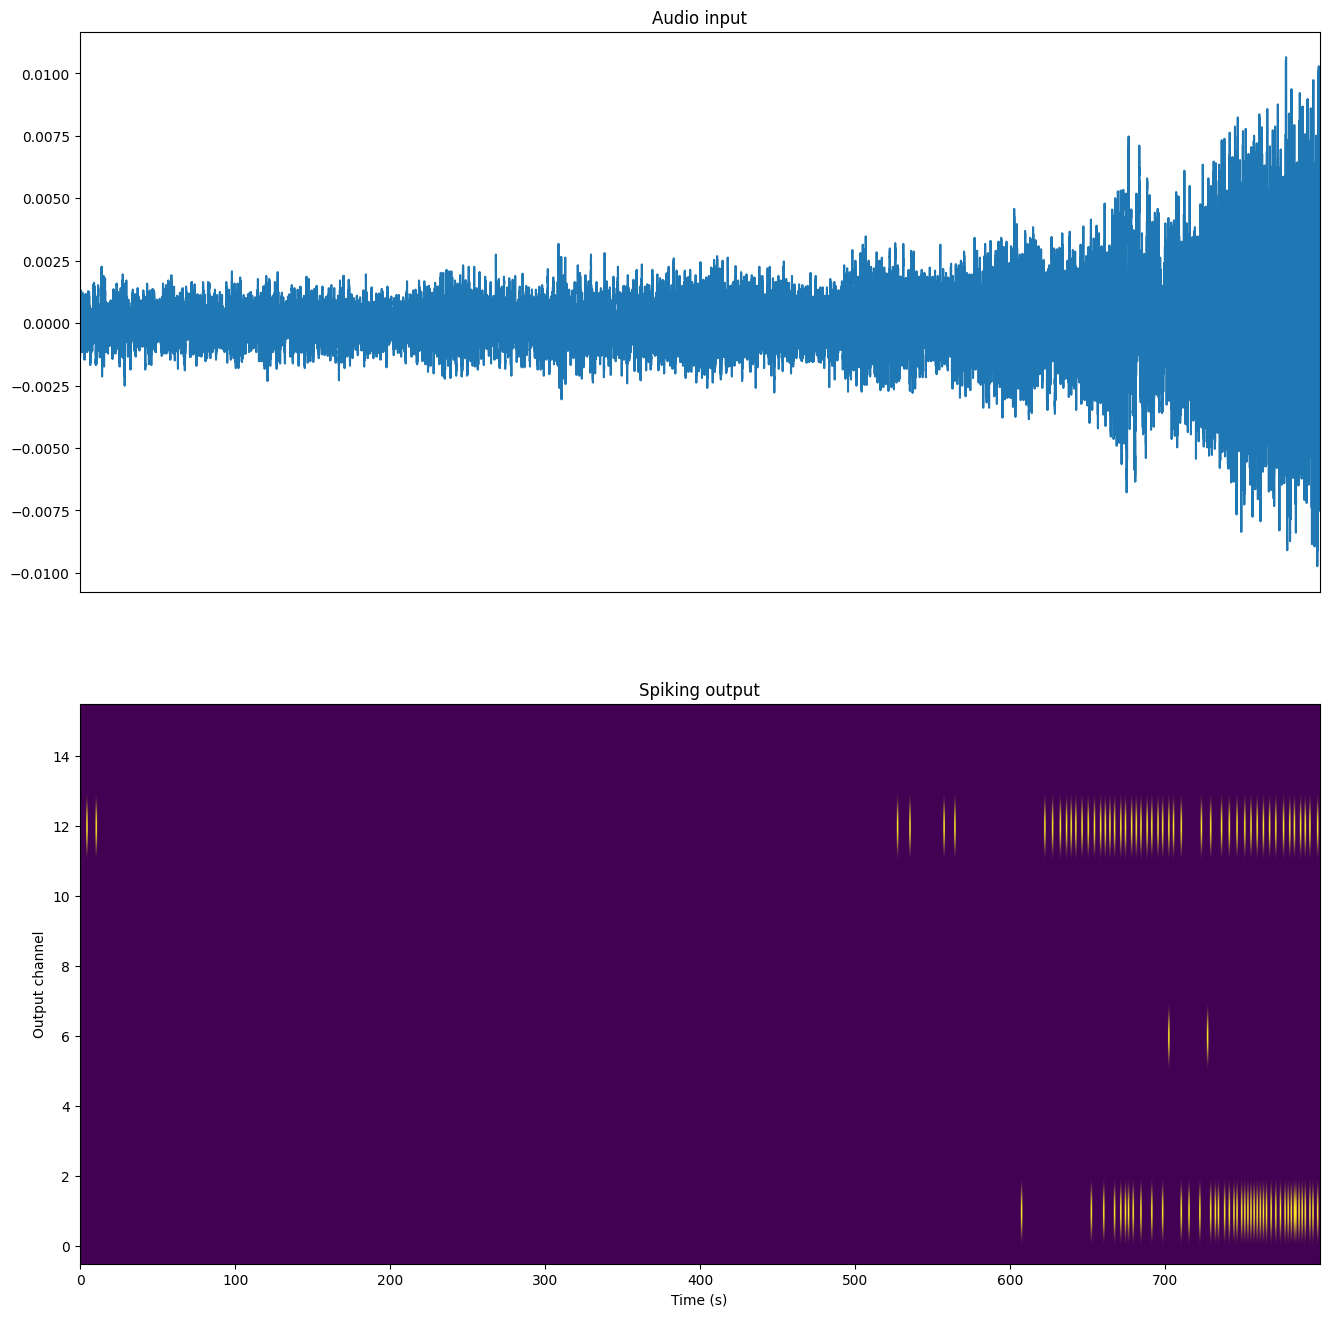

In [6]:
if __name__ == "__main__":
    logging.basicConfig(filename="spike_text.log",
                        encoding='utf-8', level=logging.DEBUG)

    script_dir = os.path.dirname(os.path.abspath('__file__'))

    # Path for two level above script directory.
    project_root = os.path.abspath(os.path.join(script_dir, "../.."))
    output_path = os.path.join(script_dir, "output")

    print(script_dir)

    flac_files = []
    for root, _, files in os.walk(project_root):
        for file in files:
            if file.lower().endswith(".flac"):
                full_path = os.path.join(root, file)
                flac_files.append(full_path)

    for file in flac_files:
        segment_and_filter(
            input_path=file, output_dir=output_path, energy_threshold=-60)

    output_files = []
    for root, _, files in os.walk(output_path):
        for file in files:
             if file.lower().endswith(".flac"):
                full_path = os.path.join(root, file)
                output_files.append(full_path)

    count = 0
    limit = 20

    for file in output_files:
        if(count >= limit):
            break
        audio_to_features(input_path=file, output_dir=os.path.join(script_dir, "npy"))
        count += 1